### Necessary Imports:

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn 

from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
import math

from sklearn.linear_model import LinearRegression

from torch import save, load, no_grad, LongTensor
from torch.utils.data import Dataset

import argparse
from numpy import arange, random
import torch.optim as optim
from torch.utils.data import DataLoader, random_split

In [ ]:
test_df = pd.read_csv("test_FD004.csv")
train_df = pd.read_csv("train_FD004.csv")

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61249 entries, 0 to 61248
Data columns (total 26 columns):
Unit        61249 non-null int64
Time        61249 non-null int64
Op1         61249 non-null float64
Op2         61249 non-null float64
Op3         61249 non-null int64
Sensor1     61249 non-null float64
Sensor2     61249 non-null float64
Sensor3     61249 non-null float64
Sensor4     61249 non-null float64
Sensor5     61249 non-null float64
Sensor6     61249 non-null float64
Sensor7     61249 non-null float64
Sensor8     61249 non-null float64
Sensor9     61249 non-null float64
Sensor10    61249 non-null float64
Sensor11    61249 non-null float64
Sensor12    61249 non-null float64
Sensor13    61249 non-null float64
Sensor14    61249 non-null float64
Sensor15    61249 non-null float64
Sensor16    61249 non-null float64
Sensor17    61249 non-null int64
Sensor18    61249 non-null int64
Sensor19    61249 non-null float64
Sensor20    61249 non-null float64
Sensor21    61249 non-null

In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41214 entries, 0 to 41213
Data columns (total 26 columns):
Unit        41214 non-null int64
Time        41214 non-null int64
Op1         41214 non-null float64
Op2         41214 non-null float64
Op3         41214 non-null int64
Sensor1     41214 non-null float64
Sensor2     41214 non-null float64
Sensor3     41214 non-null float64
Sensor4     41214 non-null float64
Sensor5     41214 non-null float64
Sensor6     41214 non-null float64
Sensor7     41214 non-null float64
Sensor8     41214 non-null float64
Sensor9     41214 non-null float64
Sensor10    41214 non-null float64
Sensor11    41214 non-null float64
Sensor12    41214 non-null float64
Sensor13    41214 non-null float64
Sensor14    41214 non-null float64
Sensor15    41214 non-null float64
Sensor16    41214 non-null float64
Sensor17    41214 non-null int64
Sensor18    41214 non-null int64
Sensor19    41214 non-null float64
Sensor20    41214 non-null float64
Sensor21    41214 non-null

### Maximum Cycles for every machine unit:

In [ ]:
# Extra max cycles for every machine unit:
max_cycles_train = train_df.groupby(['Unit'], sort=False)['Time'].max().reset_index().rename(columns={'Time':'MaxCycleID'})
max_cycles_train.head()

,Unit,MaxCycleID
0,1,321
1,2,299
2,3,307
3,4,274
4,5,193


In [ ]:
# Repeat for test data:
max_cycles_test = test_df.groupby(['Unit'], sort=False)['Time'].max().reset_index().rename(columns={'Time':'MaxCycleID'})
max_cycles_test.head()

,Unit,MaxCycleID
0,1,230
1,2,153
2,3,141
3,4,208
4,5,51


In [ ]:
train_df = pd.merge(train_df, max_cycles_train, how='inner', on='Unit')
train_df.head(1)

,Unit,Time,Op1,Op2,Op3,Sensor1,Sensor2,Sensor3,Sensor4,Sensor5,...,Sensor13,Sensor14,Sensor15,Sensor16,Sensor17,Sensor18,Sensor19,Sensor20,Sensor21,MaxCycleID
0,1,1,42.0049,0.84,100,445.0,549.68,1343.43,1112.93,3.91,...,2387.99,8074.83,9.3335,0.02,330,2212,100.0,10.62,6.367,321


In [ ]:
# Repeat for test data
test_df = pd.merge(test_df, max_cycles_test, how='inner', on='Unit')
test_df.head(1)

,Unit,Time,Op1,Op2,Op3,Sensor1,Sensor2,Sensor3,Sensor4,Sensor5,...,Sensor13,Sensor14,Sensor15,Sensor16,Sensor17,Sensor18,Sensor19,Sensor20,Sensor21,MaxCycleID
0,1,1,20.0072,0.7,100,491.19,606.67,1481.04,1227.81,9.35,...,2387.78,8048.98,9.2229,0.02,362,2324,100.0,24.31,14.7007,230


In [ ]:
# RUL for Train data
train_df['RUL'] = train_df['MaxCycleID'] - train_df['Time']
train_df.head(1)

,Unit,Time,Op1,Op2,Op3,Sensor1,Sensor2,Sensor3,Sensor4,Sensor5,...,Sensor14,Sensor15,Sensor16,Sensor17,Sensor18,Sensor19,Sensor20,Sensor21,MaxCycleID,RUL
0,1,1,42.0049,0.84,100,445.0,549.68,1343.43,1112.93,3.91,...,8074.83,9.3335,0.02,330,2212,100.0,10.62,6.367,321,320


In [ ]:
# RUL for Test data
test_df['RUL'] = test_df['MaxCycleID'] - test_df['Time']
test_df.head(1)

,Unit,Time,Op1,Op2,Op3,Sensor1,Sensor2,Sensor3,Sensor4,Sensor5,...,Sensor14,Sensor15,Sensor16,Sensor17,Sensor18,Sensor19,Sensor20,Sensor21,MaxCycleID,RUL
0,1,1,20.0072,0.7,100,491.19,606.67,1481.04,1227.81,9.35,...,8048.98,9.2229,0.02,362,2324,100.0,24.31,14.7007,230,229


Time -0.3787095846178559
Op1 -48.188876397144156
Op2 -17.01167007058314
Op3 1196.006564044887
Sensor1 402.78310544220494
Sensor2 -9.890305481449445
Sensor3 -0.8113986441892844
Sensor4 -1.33069566264754
Sensor5 -168.72223571528124
Sensor6 -49.21165496574992
Sensor7 0.12313495192207324
Sensor8 -5.012246549678878
Sensor9 -0.3719255072637405
Sensor10 -51.88333169973506
Sensor11 -72.33218735654344
Sensor12 -1.2594640271443545
Sensor13 -3.583364742478975
Sensor14 0.29448578302931594
Sensor15 -76.81360826662929
Sensor16 827.2439911633453
Sensor17 -4.047199766043562
Sensor18 -147.81378513504697
Sensor19 450.5954730038619
Sensor20 9.717277747857095
Sensor21 15.4245584685249


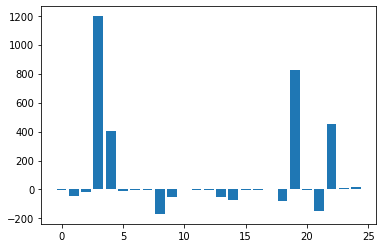

In [ ]:
# Remove maxCycleID from model; since that's a future information.
X = train_df.drop(columns=["Unit","MaxCycleID", "RUL"])
y = train_df["RUL"]

# Initiialize model
linear_model = LinearRegression()

# Fit model to data with RUL as target
linear_model.fit(X, y)

# Feature Importance information
importance = linear_model.coef_

# summarize feature importance
for i,v in enumerate(importance):
	print(X.columns[i], v)
 

# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()


In [ ]:
# Linear Regression prediction
linear_model.score(X,y)

0.6140550134192189

In [ ]:
# Exract important features:
important_features = []
for i,v in enumerate(importance):
    if v > 0:
        important_features.append(X.columns[i])
        
print("Important Features: ", important_features)

Important Features:  ['Op3', 'Sensor1', 'Sensor7', 'Sensor14', 'Sensor16', 'Sensor19', 'Sensor20', 'Sensor21']


In [ ]:
# Linear Regression score using only important features:
imporant_model = LinearRegression().fit(X[important_features], y)
important_predictions = imporant_model.predict(test_df[important_features])

rmse = sqrt(mean_squared_error(test_df["RUL"], important_predictions))
r2 = r2_score(test_df["RUL"], important_predictions)
print("RMSE Benchmark using Important Features only with Linear Regression: ", rmse)
print("R2 Score Benchmark using Important Features only with Linear Regression: ", r2)

RMSE Benchmark using Important Features only with Linear Regression:  89.36924259934992
R2 Score Benchmark using Important Features only with Linear Regression:  -0.13960569946754053


### Building Transformer Model

In [ ]:
max_len = 1000 # Reduced ,due to CUDA GPU Limitation

In [ ]:
# Defining Positional Encdoing for Transformer
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=max_len):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)


# Building the Transformer Neural Network Class
class TransformerModel(nn.Module):
    def __init__(self, intoken, outtoken, hidden, nlayers=3, dropout=0.1):
        super(TransformerModel, self).__init__()
        nhead = hidden // 64

        self.encoder = nn.Embedding(intoken, hidden)
        self.pos_encoder = PositionalEncoding(hidden, dropout)

        self.decoder = nn.Embedding(outtoken, hidden)
        self.pos_decoder = PositionalEncoding(hidden, dropout)

        self.inscale = math.sqrt(intoken)
        self.outscale = math.sqrt(outtoken)

        self.transformer = nn.Transformer(d_model=hidden, nhead=nhead, num_encoder_layers=nlayers,
                                          num_decoder_layers=nlayers, dim_feedforward=hidden, dropout=dropout)
        self.fc_out = nn.Linear(hidden, outtoken)

        self.src_mask = None
        self.trg_mask = None
        self.memory_mask = None

    def generate_square_subsequent_mask(self, sz):
        mask = torch.triu(torch.ones(sz, sz), 1)
        mask = mask.masked_fill(mask == 1, float('-inf'))
        return mask

    def make_len_mask(self, inp):
        return (inp == 0).transpose(0, 1)

    def forward(self, src, trg):
        if self.trg_mask is None or self.trg_mask.size(0) != len(trg):
            self.trg_mask = self.generate_square_subsequent_mask(len(trg)).to(trg.device)

        src_pad_mask = self.make_len_mask(src)
        trg_pad_mask = self.make_len_mask(trg)

        src = self.encoder(src)
        src = self.pos_encoder(src)

        trg = self.decoder(trg)
        trg = self.pos_decoder(trg)
        output = self.transformer(src, trg, tgt_mask=self.trg_mask)
        # output = self.transformer(src, trg, src_mask=self.src_mask, tgt_mask=self.trg_mask,
        #                           memory_mask=self.memory_mask,
        #                           src_key_padding_mask=src_pad_mask, tgt_key_padding_mask=trg_pad_mask,
        #                           memory_key_padding_mask=src_pad_mask)
        output = self.fc_out(output)

        return output

NameError: ignored

In [ ]:
# Class for Formatting Dataset input to Transformer class
class NumberLoader(Dataset):
    def __init__(self, x, y, inp_len=3, out_len=3):
        if len(x) != len(y):
            raise ValueError("len(x) != len(y)")
        self.x = [[x[i + j] for j in range(inp_len)] for i in range(len(x) - inp_len + 1)]
        self.y = [[y[i + j] for j in range(out_len)] for i in range(len(y) - out_len + 1)]

    def __getitem__(self, index):
        return LongTensor(self.x[index]), LongTensor([0] + self.y[index])

    def __len__(self):
        return len(self.x)
    
# For training the model on every epoch
def train(model, criterion, optimizer, loader):
    model.train()
    epoch_loss = 0
    for i, batch in enumerate(loader):
        src, tgt = batch
        src, tgt = src.transpose(1, 0).cuda(), tgt.transpose(1, 0).cuda()
        optimizer.zero_grad()
        output = model(src, tgt[:-1, :])
        n = output.shape[-1]
        loss = criterion(output.reshape(-1, n), tgt[1:, :].reshape(-1))
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(loader)


# FOr validating trained model
def validation(model, criterion, loader):
    model.eval()
    epoch_loss = 0
    with no_grad():
        for i, batch in enumerate(loader):
            src, tgt = batch
            src, tgt = src.transpose(1, 0).cuda(), tgt.transpose(1, 0).cuda()
            output = model(src, tgt[:-1, :])
            n = output.shape[-1]
            loss = criterion(output.reshape(-1, n), tgt[1:, :].reshape(-1))
            epoch_loss += loss.item()
    return epoch_loss / len(loader)

In [ ]:
# Function for training the model.
def main(train_df, column_name, target_column, model_name=None, hidden=64, nlayers=1, epochs = 1):
    voc_size = 100000
    inp = train_df[column_name].values
    tgt = train_df[target_column].values
    
    batch_size = 128
    #epochs = 1
    dataset = NumberLoader(inp, tgt)
    train_len = int(len(dataset) * 0.9)
    val_len = len(dataset) - train_len
    train_set, val_set = random_split(dataset, [train_len, val_len])
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=1)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=1)
    model = TransformerModel(voc_size, voc_size, hidden=hidden, nlayers=nlayers)
    if model_name is not None:
        model.load_state_dict(load(model_name))
    model = model.cuda()
    # optimizer = optim.SGD(model.parameters(), lr=0.5)
    optimizer = optim.Adam(model.parameters())
    # scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
    criterion = nn.CrossEntropyLoss()
    # best_loss = 100
    for i in range(epochs):
        epoch_loss = train(model, criterion, optimizer, train_loader)
        epoch_loss_val = validation(model, criterion, val_loader)
        # scheduler.step()
        print("epoch: {} train loss: {}".format(i, epoch_loss))
        print("epoch: {} val loss: {}".format(i, epoch_loss_val))
#         if epoch_loss_val < best_loss:
#             best_loss = epoch_loss_val
#             model_name = "model/model_{0:.5f}.pt".format(epoch_loss_val)
#             save(model.state_dict(), model_name)
    return model#model_name

In [ ]:
def run_test(model, val):
    model = model.cuda()
    model.eval()
    
    src = LongTensor(val).unsqueeze(1).cuda()
    pred = [0]
    for j in range(len(val)):
        inp = LongTensor(pred).unsqueeze(1).cuda()
        output = model(src, inp)
        out_num = output.argmax(2)[-1].item()
        pred.append(out_num)

    return pred[1:]
    

In [ ]:
# Selected columns for train:
x_columns = important_features
print("Using only important features for training: ", x_columns)

In [ ]:
# def batch_models(x_columns, train_df, test_df, epochs=1):
#     # Batch execution of training for every column.
#     batch_dict = {}
#     for column_name in x_columns:
#         print("Training: ", column_name)
#         model = main(train_df, column_name, "RUL", epochs=epochs)


In [ ]:
def batch_execution(x_columns, train_df, test_df, epochs=1):
    # Batch execution of training/testing for every column.
    batch_dict = {}
    for column_name in x_columns:
        print("Training: ", column_name)
        model = main(train_df, column_name, "RUL", epochs=epochs)

        predictions = []
        # Predict model on test
        val = test_df[column_name][:max_len] #Predictions should be done in batch based on max_len due to limitations on GPU
        pred = run_test(model, val)
        predictions.extend(pred)

        # Predicting in batches due to CUDA GPU Limitation; (max_len has to be adjusted for this.)
        last_batch = max_len
        while True:
            if last_batch < len(test_df[column_name]): #If any more predictions left
                pred = run_test(model, test_df[column_name][last_batch : last_batch+max_len].tolist())
                predictions.extend(pred)
            else:
                break

            print(last_batch, "last_batch")

            last_batch += max_len

        batch_dict[column_name] = predictions

    row_length = len(batch_dict[column_name]) #Get length of data rows

    # Aggregate batch predictions for every row in batch.
    target_predictions = []
    for row in range(row_length):
        row_values = []
        for column in batch_dict:
            #columns_predictions.append(batch_result[column])
            value = batch_dict[column][row]
            row_values.append(value)

        pred = sum(row_values)/len(row_values)
        target_predictions.append(pred)




    return target_predictions


In [ ]:
def evaluate_predictions(predictions):    
    rmse = sqrt(mean_squared_error(test_df["RUL"], predictions))
    r2 = r2_score(test_df["RUL"], target_predictions)
    
    
    print("RMSE = ", rmse)
    print("R2 = ", r2_score)

In [ ]:
predictions = batch_execution(x_columns, train_df, test_df, epochs=2)

In [ ]:
evaluate_predictions(target_predictions)

In [ ]:
np.array([[0,0,0,0],[1,1,1,1],[1,2,3,4], [3,3,3,3]]).shape[-1]

4